The following notebook will create a model to predict ( or classify ) whether a given swiss product review is helpful or not.

This notebook follows the same steps as the predicting_helpfulness_small notebook, the main diference being that this one uses a larger dataset of helpful reviews.

The links towards the papers that inspired this work should be available here: ["Predicting Amazon review helpfulness"](https://cseweb.ucsd.edu/~jmcauley/cse255/reports/wi15/Shitij_Bhargava.pdf) and ["Predicting Helpfulness Ratings of Amazon Product Reviews"](http://cs229.stanford.edu/proj2014/Jordan%20Rodak,%20Minna%20Xiao,%20Steven%20Longoria,%20Predicting%20Helpfulness%20Ratings%20of%20Amazon%20Product%20Reviews.pdf)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml

Open the file containing the filtered helpful swiss reviews. This notebook uses the bigger such dataset, in which the swiss reviews had at least 5 helpful flags (votes) and totalling to 23755 reviews.

In [3]:
with open("data/swiss-reviews-helpful-correct-bigger.txt", 'r') as fp:
    s_swiss_rev_help = fp.readlines()

In [4]:
len(s_swiss_rev_help)

23755

In [5]:
s_swiss_rev_help[0]

'{"reviewerID": "A05423363IP01ZGDN77PM", "asin": "B006TIEY40", "reviewerName": "Francis C.", "helpful": [4, 6], "reviewText": "Have used it for several trips already. Very satisfied. Fits in overhead compartment. Excellent quality and so far durable. Great for overnight trips.", "overall": 5.0, "summary": "Perfect carry-on spinner", "unixReviewTime": 1372032000, "reviewTime": "06 24, 2013"}\n'

The ARI score is a measure of the readability of a piece of text and it represents one of the features in the later model.

In [6]:
import re
import nltk.data
from nltk import wordpunct_tokenize

# split into words by punctuations
# remove punctuations and all '-' words
RE = re.compile('[0-9a-z-]', re.I)
s_sent = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
def get_ARI_score(text):
    words = list(filter(lambda w: RE.search(w) and w.replace('-', ''), wordpunct_tokenize(text)))
    wordc = len(words)
    charc = sum(len(w) for w in words)
    sents = s_sent.tokenize(text)
    sentc = len(sents)
    return 4.71 * charc / (wordc + 0.1) + 0.5 * (wordc + 0.1) / (sentc + 0.1) - 21.43

In the next step we convert the file containing the reviews into a pandas dataframe as it is easier to work with it in that format.

In [8]:
def convert_to_dict(line):
    l = line.rstrip('\n')
    l = eval(l)
    return l

In [9]:
s_dict_list = []
counter = 1
for item in s_swiss_rev_help:
    if(counter%500 == 0):
        print(counter)
    counter += 1
    s_dict_list.append(convert_to_dict(item))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500


In [10]:
s_features = pd.DataFrame(s_dict_list)

We remove the 'reviewTime', 'reviewerName', 'unixReviewTime' columns from the dataframe as they will not be used as features nor used to construct other features. As a note, in the papers which inspired the current work these columns were used to obtain features such as the age of a review and the time delay of the review.

In [11]:
s_features.drop(['reviewTime', 'reviewerName', 'unixReviewTime'],inplace=True,axis=1)

In [12]:
s_features.head(3)

,asin,helpful,overall,reviewText,reviewerID,summary
0,B006TIEY40,"[4, 6]",5.0,Have used it for several trips already. Very s...,A05423363IP01ZGDN77PM,Perfect carry-on spinner
1,B006TIEZH6,"[4, 6]",5.0,Have used it for several trips already. Very s...,A05423363IP01ZGDN77PM,Perfect carry-on spinner
2,B001F42MKG,"[0, 6]",1.0,dont buy this crap. hard to use. doesnt last l...,A05953714NT40ISVAAT5,dont buy this crap


### Feature gathering

Feature 1: Review length measured by the number of characters of the text.
It will be noted here that after the creation of each feature it will also be standardized.

In [13]:
# Review length
s_features["rev_length"] = s_features['reviewText'].apply(lambda x: len(x))
s_features["rev_length"] = (s_features["rev_length"] - \
                          s_features["rev_length"].mean()) / s_features["rev_length"].std()

Feature 2: The ratio of the number of caps to the total number of characters. +1 was added in the denominator to prevent division by 0 (apparently there are zero-length reviews).

In [14]:
# Number of all caps
def count_all_caps(text):
    count = 0
    for i in text:
        if(i.isupper()):
            count += 1
    return count/(len(text) + 1)

In [15]:
s_features["all_caps"] = s_features['reviewText'].apply(count_all_caps)
s_features["all_caps"] = (s_features["all_caps"] - \
                          s_features["all_caps"].mean()) / s_features["all_caps"].std()

Feature 3: Total number of sentences

In [16]:
# Sentence count
s_features["sent_count"] = s_features['reviewText'].apply(lambda x: \
                                                      len(nltk.tokenize.sent_tokenize(x)))

In [17]:
s_features["sent_count"] = (s_features["sent_count"] - \
                          s_features["sent_count"].mean()) / s_features["sent_count"].std()

Feature 4: Question and exclamation marks ratio to the length of the text

In [18]:
# Question and exclamation marks ratio to characters
def count_ques_exc_ratio(text):
    count = 0
    for i in text:
        if(i == '!' or i == '?'):
            count += 1
    return count*1.0/(len(text)+1)

In [19]:
s_features["que_exc_ratio"] = s_features['reviewText'].apply(count_ques_exc_ratio)
s_features["que_exc_ratio"] = (s_features["que_exc_ratio"] - \
                          s_features["que_exc_ratio"].mean()) / s_features["que_exc_ratio"].std()

Feature 5: ARI readability score

In [20]:
# ARI readability index
s_features["ari_score"] = s_features['reviewText'].apply(get_ARI_score)

In [21]:
s_features["ari_score"] = (s_features["ari_score"] - \
                          s_features["ari_score"].mean()) / s_features["ari_score"].std()

Feature 6: The deviation of the review's rating from the mean rating score of the respective product

In [22]:
# load mean rating scores for considered asins
with open("data/asin_ratings_bigger.json", "r") as fp:
    s_asin_rev_ratings = fp.readlines()

In [23]:
s_dict_list_ar = []
for item in s_asin_rev_ratings:
    s_dict_list_ar.append(convert_to_dict(item))

In [24]:
s_dict_ar = dict([(key,d[key]) for d in s_dict_list_ar for key in d])

In [25]:
def get_dev_mean_score(row):
    if(row['asin'] in s_dict_ar.keys()):
        return row['overall'] - s_dict_ar[row['asin']]
    print("Should not get here")
    return 0

In [26]:
s_features['dev_mean_score'] = s_features.apply(get_dev_mean_score, axis=1)

In [27]:
# should only be standardized after dev_mean_score has been computed
s_features["overall"] = (s_features["overall"] - \
                          s_features["overall"].mean()) / s_features["overall"].std()

In [28]:
s_features["dev_mean_score"] = (s_features["dev_mean_score"] - \
                          s_features["dev_mean_score"].mean()) / s_features["dev_mean_score"].std()

In [29]:
len(s_features)

23755

In the next step we remove duplicate ('asin', 'reviewText') pair values. There other approaches as well as removing duplicates only by the 'reviewText' field, but this would reduce the dataset considerably. Here we can make an interesting observation, regarding the fact that a lot of the reviews are copied in different products, without changing the content at the very least. 

In [30]:
s_features.drop_duplicates(subset=['asin','reviewText'], keep='first', inplace=True)

In [31]:
len(s_features)

23675

In the next part we create the labels by considering a review 'helpful' only if it has at least 0.6 helpful ratio (helpful votes / total votes). This approach was also used in the mentioned papers, the motivation being that the normal/intuitive threshold of 0.5 would be a little ambiguous and as such a more strict threshold was used.

In [32]:
def create_labels(pair):
    if(pair[0]*1.0/pair[1] >= 0.6):
        return 1
    else:
        return 0

In [33]:
s_features['Y'] = s_features['helpful'].apply(create_labels)

To complete the set of features considered for the learning model we use tf-idf on the corpus of helpful reviews. In a little more detail we first compute the dictionary of the corpus and then attach to each word its tf-idf score. A given review will contain as features the vocabulary of words together with the tf-idf scores for its respective words contained in the review.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
s_count_vect = CountVectorizer(stop_words='english')
s_X_train_counts = s_count_vect.fit_transform(list(s_features['reviewText']))

In [35]:
s_X_train_counts.shape

(23675, 49576)

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
s_tf_transformer = TfidfTransformer().fit(s_X_train_counts)
s_X_train_tf = s_tf_transformer.transform(s_X_train_counts)

In [37]:
s_X_train_tf.shape

(23675, 49576)

In order to preserve the sparsity we scale by the maximum absolute value.

In [38]:
from sklearn.preprocessing import scale, maxabs_scale

In [39]:
maxabs_scale(s_X_train_tf, copy=False)

<23675x49576 sparse matrix of type '<class 'numpy.float64'>'
	with 1396844 stored elements in Compressed Sparse Row format>

In [40]:
s_Y = s_features.as_matrix(['Y'])

In [41]:
s_Y.shape

(23675, 1)

In [42]:
s_X_train_else = s_features.as_matrix(['overall','rev_length','all_caps','sent_count','que_exc_ratio',
                                   'ari_score', 'dev_mean_score'])

In [43]:
type(s_X_train_else)

numpy.ndarray

We combine the features constructed until now into the final feature matrix s_X

In [44]:
from scipy.sparse import hstack
s_X = hstack([s_X_train_tf, s_X_train_else])

In [45]:
type(s_X)

scipy.sparse.coo.coo_matrix

In [46]:
s_X.shape

(23675, 49583)

In [47]:
s_Y.shape

(23675, 1)

In [48]:
s_Y = s_Y.reshape((s_Y.shape[0],))

In [49]:
s_Y.shape

(23675,)

### Time for some machine learning

Load the classifier models to be tested: Random forest, Logistic regression, AdaBoost, SVC (from SVM)

In [50]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc

Split the dataset into training and testing and see how the classifiers roughly behave

In [51]:
x_tr, x_te, y_tr, y_te = train_test_split(s_X, s_Y, train_size=0.8)

In [52]:
s_cllr = LogisticRegression(class_weight='balanced', n_jobs=-1, C=1e2)

In [53]:
s_cllr.fit(x_tr, y_tr)
print("Test set accuracy:" , s_cllr.score(x_te, y_te))
print("Train set accuracy:", s_cllr.score(x_tr, y_tr))

Test set accuracy: 0.808658922914
Train set accuracy: 0.999208025343


In [54]:
s_clrf = RandomForestClassifier(n_estimators = 10, class_weight='balanced', n_jobs=-1)

In [55]:
s_clrf.fit(x_tr, y_tr)
print("Test set accuracy:" , s_clrf.score(x_te, y_te))
print("Train set accuracy:", s_clrf.score(x_tr, y_tr))

Test set accuracy: 0.823020063358
Train set accuracy: 0.993505807814


In [56]:
s_clab = AdaBoostClassifier()

In [57]:
s_clab.fit(x_tr, y_tr)
print("Test set accuracy:" , s_clab.score(x_te, y_te))
print("Train set accuracy:", s_clab.score(x_tr, y_tr))

Test set accuracy: 0.813305174234
Train set accuracy: 0.820749736008


Note: Unfortunately the SVC (linear SVM) classifier takes a long time to compute and it was removed from the analysis.

In [58]:
sum(y_tr)/len(y_tr)

0.75443505807814149

The accuracy does not bring any meaningful observations as the 2 classes are highly imbalanced. The ratio of the positive (helpful) samples to the negative (unhelpful) samples is approximately 3:1.

One alternative is to compute the F1 score for each classfier using cross-validation

In [59]:
shuffle = KFold(n_splits=10, shuffle=True)

In [60]:
f1s_rf = cross_val_score(s_clrf, s_X, s_Y, cv=shuffle, scoring='f1', n_jobs=-1)

In [61]:
print("F1 score mean -- Random forest:" , f1s_rf.mean())
print("F1 score std -- Random forest:", f1s_rf.std())

F1 score mean -- Random forest: 0.885844405397
F1 score std -- Random forest: 0.00656460934811


In [62]:
f1s_lr = cross_val_score(s_cllr, s_X, s_Y, cv=shuffle, scoring='f1', n_jobs=-1)

In [63]:
print("F1 score mean -- Logistic regression:" , f1s_lr.mean())
print("F1 score std -- Logistic regression:", f1s_lr.std())

F1 score mean -- Logistic regression: 0.875015012955
F1 score std -- Logistic regression: 0.00675991385759


In [64]:
f1s_ab = cross_val_score(s_clab, s_X, s_Y, cv=shuffle, scoring='f1', n_jobs=-1)

In [65]:
print("F1 score mean -- AdaBoost:" , f1s_ab.mean())
print("F1 score std -- AdaBoost:", f1s_ab.std())

F1 score mean -- AdaBoost: 0.878867782696
F1 score std -- AdaBoost: 0.00774506029495


Based on the F1 score, the Random Forest classifier seems to be doing a little bit better than the Logistic Regression and AdaBoost classifiers.

Next we can also take a look at the confusion matrix for each model.

In [66]:
s_y_pred_rf = cross_val_predict(s_clrf, s_X, s_Y, cv=shuffle, n_jobs=-1)

In [67]:
s_y_pred_lr = cross_val_predict(s_cllr, s_X, s_Y, cv=shuffle, n_jobs=-1)

In [68]:
s_y_pred_ab = cross_val_predict(s_clab, s_X, s_Y, cv=shuffle, n_jobs=-1)

In [69]:
s_cm_rf = confusion_matrix(s_Y, s_y_pred_rf)

In [70]:
s_cm_lr = confusion_matrix(s_Y, s_y_pred_lr)

In [71]:
s_cm_ab = confusion_matrix(s_Y, s_y_pred_ab)

In [72]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 3267  2563]
 [ 1545 16300]]


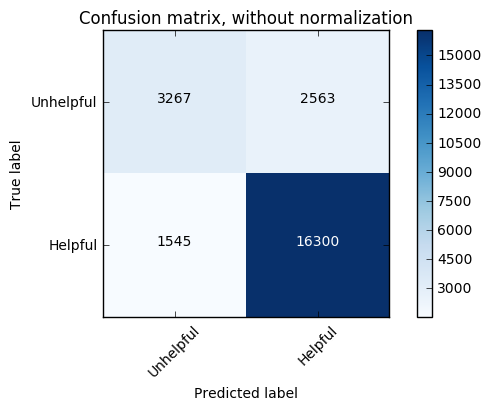

In [73]:
# Plot non-normalized confusion matrix -- Random forest
plt.figure()
plot_confusion_matrix(s_cm_rf, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[ 3725  2105]
 [ 2254 15591]]


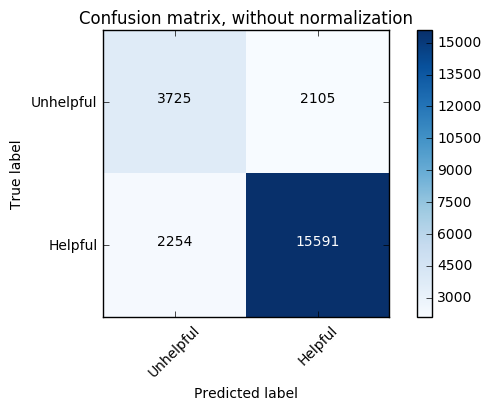

In [74]:
# Plot non-normalized confusion matrix -- Logistic regression
plt.figure()
plot_confusion_matrix(s_cm_lr, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[ 2901  2929]
 [ 1570 16275]]


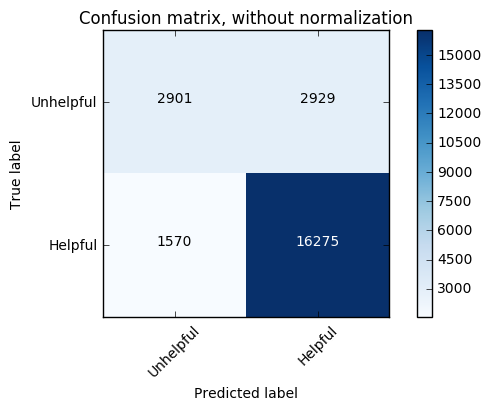

In [75]:
# Plot non-normalized confusion matrix -- AdaBoost
plt.figure()
plot_confusion_matrix(s_cm_ab, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

After preforming cross-validation to find the predictions of each model, we plotted the confusion matrix with respect to each model's predictions. 

There are different measurements based on the confusion matrix, the F1 score (harmonic mean between precision and recall) computed before being one of them. One measurement which could be more useful is the false positive rate (FP / N; FP = false positives, N = total negatives). The intuition behind this is the following: classifying true helpful reviews as unhelpful is less significant than classifying true unhelpful reviews as helpful. We see that all the models perform well in identifying helpful reviews, yet some are better at handling the unhelpful reviews. The false positive rate focuses on finding which model is better or more sensitive for handling negative samples (unhelpful reviews).

In [76]:
tn_rf, fp_rf, fn_rf, tp_rf = s_cm_rf.ravel()

In [77]:
false_positive_rate_rf = fp_rf / (fp_rf + tn_rf)
false_positive_rate_rf

0.43962264150943398

In [78]:
tn_lr, fp_lr, fn_lr, tp_lr = s_cm_lr.ravel()

In [79]:
false_positive_rate_lr = fp_lr / (fp_lr + tn_lr)
false_positive_rate_lr

0.36106346483704976

In [80]:
tn_ab, fp_ab, fn_ab, tp_ab = s_cm_ab.ravel()

In [81]:
false_positive_rate_ab = fp_ab / (fp_ab + tn_ab)
false_positive_rate_ab

0.50240137221269299

Logistic regression (again) provides the smallest false positive rate, suggesting that it is the better model for handling the negative cases

Next measurement step will be to analyze the roc curves for each model.

In [82]:
# with StratifiedKFold the folds are made by preserving the percentage of samples for each class
shuffle_5 = StratifiedKFold(n_splits=5, shuffle=True)

In [83]:
from itertools import cycle
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue'])

In [84]:
from scipy import interp
def plot_roc_cv(classifier):
    i = 0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for (train, test), color in zip(shuffle_5.split(s_X, s_Y), colors):
        classifier.fit(s_X.tocsr()[train], s_Y[train])
        probas_ = classifier.predict_proba(s_X.tocsr()[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(s_Y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=color, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
        i += 1
        
    mean_tpr /= shuffle_5.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='r', linestyle='--', label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

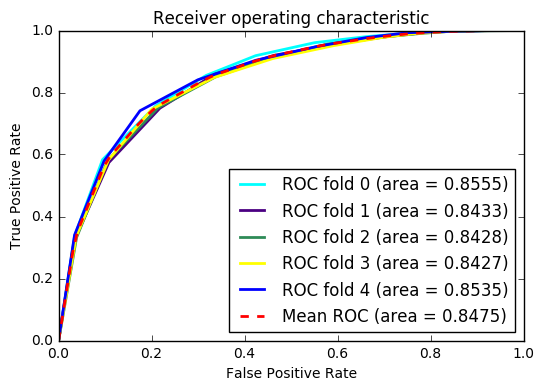

In [85]:
# ROC curve(s) for Random Forest
plt.figure()
plot_roc_cv(s_clrf)
plt.show()

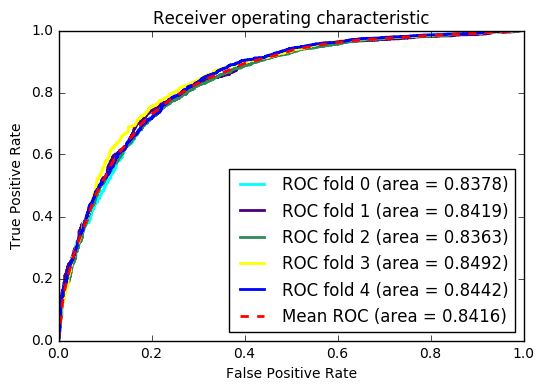

In [86]:
# ROC curve(s) for Logistic Regression
plt.figure()
plot_roc_cv(s_cllr)
plt.show()

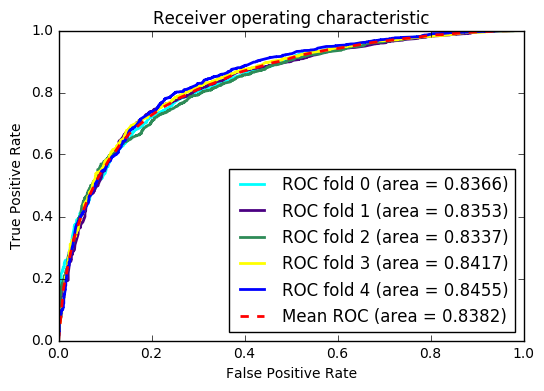

In [87]:
# ROC curve(s) for AdaBoost
plt.figure()
plot_roc_cv(s_clab)
plt.show()

Based on the results above, random forest provides the best mean roc area under curve, followed by the logistic regression.

After observing the results of the F1 score, FPR (false positive rate) and the area under the ROC curve (AUC) both the random forest and the logistic regression models seem perform better than AdaBoost, however between the two of them it is hard to say which is better as their results are quite similar.

### Most relevant features

In the last part of the analysis we try to get an intuition of the most relevant features when training the random forest. For the other classifiers identifying the most important features it is not as straight forward as for a random forest.

s_feature_names stores the name of the features (the vocabulary together with the constructed features)

In [88]:
s_words_list = s_count_vect.get_feature_names()
s_other_feats = ['overall','rev_length','all_caps','sent_count','que_exc_ratio',
                                   'ari_score', 'dev_mean_score']
s_feature_names = s_words_list + s_other_feats

In [89]:
len(s_feature_names) == s_X.shape[1]

True

In [90]:
# the number of the most relevant features to be plotted
number_of_features = 15
importances = s_clrf.feature_importances_
# sort the indices based on the importance values
indices = np.argsort(importances)[::-1]

# the names of the features based on the indices and how many to select
temp_names = []
for i in range(number_of_features):
    temp_names.append(s_feature_names[indices[i]])

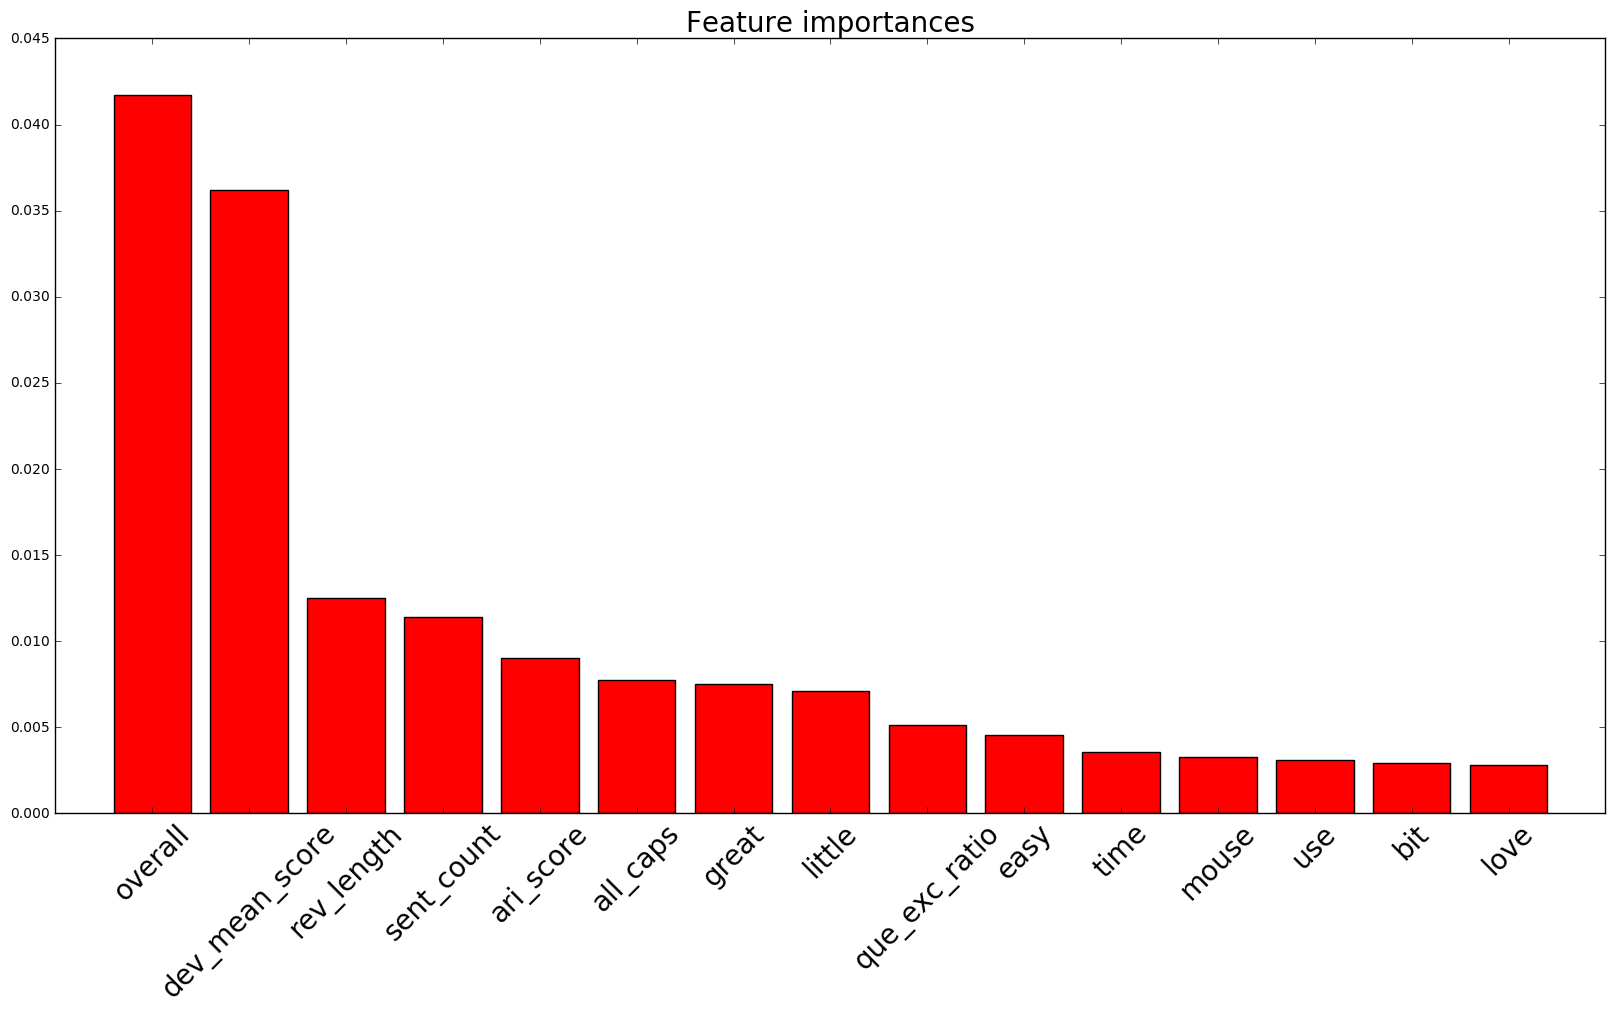

Feature ranking:
1. feature overall (0.041733)
2. feature dev_mean_score (0.036224)
3. feature rev_length (0.012483)
4. feature sent_count (0.011424)
5. feature ari_score (0.009004)
6. feature all_caps (0.007740)
7. feature great (0.007492)
8. feature little (0.007119)
9. feature que_exc_ratio (0.005137)
10. feature easy (0.004543)
11. feature time (0.003565)
12. feature mouse (0.003296)
13. feature use (0.003090)
14. feature bit (0.002937)
15. feature love (0.002801)


In [91]:
# Plot the feature importances of the random forest
plt.figure(figsize=(20,10))
plt.title("Feature importances", fontsize=20)
plt.bar(range(number_of_features), importances[indices[:number_of_features]],
       color="r", align="center")#, yerr=std[indices])
plt.xticks(range(number_of_features), temp_names, fontsize=20, rotation=45)
plt.xlim([-1, number_of_features])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(number_of_features):
    print("%d. feature %s (%f)" % (f + 1,  s_feature_names[indices[f]], importances[indices[f]]))
